# Exploratory Analysis

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import datetime, json, os, re, zstandard
from nltk.corpus import stopwords
from zst_processor import read_lines_zst, write_line_zst

In [2]:
subreddits = ["Conservative", "progressive",
              "democrats", "Republican",
              "NeutralPolitics", "PoliticalDiscussion", "politics"]

# Unigrams and Bigrams Frequency

In [3]:
from collections import Counter
from nltk.util import ngrams

In [4]:
# Count terms frequencies (unigram and bigram) in the comments
def count_terms_frequency(input_comments: list, output_frequencies: list) -> None:

    # Load stop words using nltk
    stop_words = stopwords.words('english')

    # Loop through input paths
    for in_comment, out_grams in zip(input_comments, output_frequencies):

        unigrams = Counter()
        bigrams = Counter()

        for line, file_bytes_processed in read_lines_zst(in_comment):

            # Load the json object
            obj = json.loads(line)

            # Skip if body doesn't exist
            if 'body' not in obj:
                continue

            # Get body of comment
            body = obj['body']

            # Clean the text
            body = clean_comments(body, stop_words)

            # Split the text into unigrams and bigrams
            unigrams_list = body.split()
            bigrams_list = list(ngrams(unigrams_list, 2))

            unigrams.update(unigrams_list)
            bigrams.update(bigrams_list)

        # Create the zst handler
        handle_unigram = zstandard.ZstdCompressor().stream_writer(open(out_grams[0], 'wb'))

        # Write the unigrams to the zst file
        for unigram in unigrams:
            line = {'term': unigram, 'frequency': unigrams[unigram]}
            line = json.dumps(line)
            write_line_zst(handle_unigram, line)

        # Create the zst handler
        handle_bigram = zstandard.ZstdCompressor().stream_writer(open(out_grams[1], 'wb'))

        # Write the bigrams to the zst file
        for bigram in bigrams:
            line = {'term': bigram, 'frequency': bigrams[bigram]}
            line = json.dumps(line)
            write_line_zst(handle_bigram, line)
    
    return

In [5]:
input_comments = [f"data/{s}/{s}_comments_clean.zst" for s in subreddits]
output_frequencies = [(f"analysis/ngrams/{s}_comments_unigrams.zst", f"analysis/ngrams/{s}_comments_bigrams.zst") for s in subreddits]

In [ ]:
count_terms_frequency(input_comments, output_frequencies)

### Analyze Unigrams and Bigrams

In [4]:
# Load unigrams
unigrams = {}
for subreddit in subreddits:
    unigrams[subreddit] = {}
    for line, file_bytes_processed in read_lines_zst(f"analysis/ngrams/{subreddit}_comments_unigrams.zst"):
        obj = json.loads(line)
        unigrams[subreddit][obj["term"]] = obj["frequency"]

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
stop_words = stopwords.words('english')
stop_words = [re.sub("'", "", word) for word in stop_words]
stop_words += ["like", "ever", "ive", "always", "final", "people", "would", "rrepublican", "rneutralpolitics", "get", "one", "thats", "trump", "karma", "said"]
# Function to clean unigrams
def clean_unigrams(unigrams: dict, min_frequency: int=10, max_frequency: int=1000) -> dict:

    # Strip whitespace
    unigrams = {k.strip(): v for k, v in unigrams.items()}
    
    # Remove stop words
    unigrams = {k: v for k, v in unigrams.items() if k not in stop_words}
    
    # Remove terms with frequency less than min_frequency
    unigrams = {k: v for k, v in unigrams.items() if v >= min_frequency}

    # Remove terms with frequency more than max_frequency
    unigrams = {k: v for k, v in unigrams.items() if v <= max_frequency}

    return unigrams

In [7]:
unigrams_clean = {}
for subreddit in subreddits:
    unigrams_clean[subreddit] = clean_unigrams(unigrams[subreddit], min_frequency=10, max_frequency=10000)

In [8]:
# Calculate unigram frequencies for each subreddit
unigrams_frequencies = {}
for subreddit in subreddits:
    total = sum(unigrams[subreddit].values())
    unigrams_frequencies[subreddit] = {k: v/total for k, v in unigrams[subreddit].items()}

    # Remove stop words
    unigrams_frequencies[subreddit] = {k: v for k, v in unigrams_frequencies[subreddit].items() if k not in stop_words}

    # Remove terms with frequency in the top 1%
    unigrams_frequencies[subreddit] = {k: v for k, v in unigrams_frequencies[subreddit].items() if v < 0.002}
    

In [24]:
# Plot a word cloud for each subreddit using the top 100 unigrams
for subreddit in subreddits:

    # Create the word cloud
    wc = WordCloud(background_color="white", max_words=150, width=800, height=400)
    wc.generate_from_frequencies(unigrams_clean[subreddit])

    # Plot the word cloud
    plt.figure(figsize=(16,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {subreddit}")
    #plt.show()

    # Save the image
    plt.tight_layout(pad=0)
    plt.savefig(f"analysis/ngrams/plots/{subreddit}_comments_2_wordcloud.png")

    # Close the plot
    plt.close()

In [30]:
# Plot a bar chart of the 20 most frequent unigrams for each subreddit
for subreddit in subreddits:
    
    # Get the top 20 unigrams
    top_20_unigrams = dict(sorted(unigrams_clean[subreddit].items(), key=lambda item: item[1], reverse=True)[:20])

    # Plot the bar chart horizontally using seaborn. Use yellowgreen as the color with gradient
    plt.figure(figsize=(8,8))
    sns.barplot(x=list(top_20_unigrams.values()), y=list(top_20_unigrams.keys()), palette="YlGnBu_r")

    # Set the title and axis labels
    plt.title(f"Top 20 Unigrams for {subreddit}")
    plt.xlabel("Frequency")
    plt.ylabel("Unigram")

    # Save the image
    plt.tight_layout(pad=0)
    plt.savefig(f"analysis/ngrams/plots/{subreddit}_comments_clean_unigrams_top20.png")
    #plt.show()
    plt.close()

In [40]:
# Compare unigram frequency between Republican and Democrat subreddits of top 100 unigrams
# Create a dataframe of the top 100 unigrams for each subreddit
df_unigrams = pd.DataFrame(unigrams_frequencies)
df_unigrams = df_unigrams.fillna(0)

In [41]:
df_unigrams

,Conservative,progressive,democrats,Republican,NeutralPolitics,PoliticalDiscussion,politics
die,0.000354,0.000349,0.000297,0.000294,0.000089,0.000216,2.248652e-04
able,0.000597,0.000572,0.000522,0.000486,0.000614,0.000690,5.463000e-04
afford,0.000153,0.000256,0.000134,0.000125,0.000132,0.000161,1.656714e-04
healthcare,0.000283,0.000585,0.000412,0.000274,0.000296,0.000553,4.594411e-04
aca,0.000015,0.000115,0.000081,0.000016,0.000073,0.000129,7.595825e-05
...,...,...,...,...,...,...,...
predictespecially,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.098700e-09
looksa,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.098700e-09
massprivatizationof,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.098700e-09
falsedillemma,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.098700e-09


In [58]:
# Plot scatterplot of unigram frequency between two subreddits (select top 100 unigrams)
s_1 = "democrats"
s_2 = "politics"

# Create the scatterplot
plt.figure(figsize=(8,8))
plt.scatter(df_unigrams[s_1], df_unigrams[s_2], alpha=0.5)

# Set the title and axis labels
plt.title(f"Unigram Frequency Comparison between {s_1} and {s_2}")
plt.xlabel(f"Frequency of {s_1}")
plt.ylabel(f"Frequency of {s_2}")

# Anotate the top 10 unigrams
for i, unigram in enumerate(df_unigrams.index):
    if i < 10:
        plt.annotate(unigram, (df_unigrams.loc[unigram, s_1], df_unigrams.loc[unigram, s_2]),
                     fontweight="bold", backgroundcolor="white")
    else:
        break

# Add a line with slope 1
plt.plot([0, 0.002], [0, 0.002], color="grey", linestyle="--")

plt.savefig(f"analysis/ngrams/plots/{s_1}_{s_2}_unigram_frequency_comparison.png")
#plt.show()
plt.close()

In [ ]:
# Compare unigram frequency between Republican and Democrat subreddits, and between Conservative and Progressive subreddits
for subreddit1, subreddit2 in [("Republican", "democrats"), ("Conservative", "progressive")]:

    # Get the top 20 unigrams
    top_20_unigrams1 = {k: v for k, v in sorted(unigrams[subreddit1].items(), key=lambda item: item[1], reverse=True)[:20]}
    top_20_unigrams2 = {k: v for k, v in sorted(unigrams[subreddit2].items(), key=lambda item: item[1], reverse=True)[:20]}

    # Plot the bar chart
    plt.figure(figsize=(16,8))
    plt.bar(top_20_unigrams1.keys(), top_20_unigrams1.values(), label=subreddit1)
    plt.bar(top_20_unigrams2.keys(), top_20_unigrams2.values(), label=subreddit2)
    plt.xticks(rotation=45)
    plt.title(f"Top 20 Unigrams for {subreddit1} and {subreddit2}")
    plt.legend()
    plt.show()

    # Save the image
    #plt.tight_layout(pad=0)
    #plt.savefig(f"analysis/ngrams/plots/{subreddit1}_{subreddit2}_comments_unigrams_top20.png")

In [83]:
# Load bigrams
bigrams = {}
for subreddit in subreddits:
    bigrams[subreddit] = {}
    for line, file_bytes_processed in read_lines_zst(f"analysis/ngrams/{subreddit}_comments_bigrams.zst"):
        obj = json.loads(line)
        bigrams[subreddit][tuple(obj["term"])] = obj["frequency"]

In [97]:
# Count the total frequency of bigrams in each subreddit
total_bigrams = {}
for subreddit in subreddits:
    total_bigrams[subreddit] = sum(bigrams[subreddit].values())

In [91]:
results_bigrams = {}

In [103]:
# Bigrams that show disagreement:
# - dont agree
# - disagree with/that/on/about
for s in subreddits:
    f = bigrams[s][("dont", "agree")]
    print(f"{s}: {f/total_bigrams[s]:.8f}")

Conservative: 0.00011325
progressive: 0.00007762
democrats: 0.00007669
Republican: 0.00010815
NeutralPolitics: 0.00003501
PoliticalDiscussion: 0.00006631
politics: 0.00006496


In [ ]:
result = {}
b_1, b_2 = ("i", "argue")
for s in subreddits:
    f = bigrams[s][(b_1, b_2)]
    f_total = f/total_bigrams[s]
    result[s] = f_total

# Plot result using seaborn
plt.figure(figsize=(8,8))

# Get the x and y values sorted by x
y = sorted(result.keys(), key=lambda k: result[k], reverse=True)
x = [result[k] for k in y]

# Plot the bar chart horizontally using seaborn. Use yellowgreen as the color with gradient
sns.barplot(x=x, y=y, palette="YlGnBu_r")

# Set the title and axis labels
plt.title(f"Frequency of Bigram ({b_1}, {b_2}) in Subreddits")
plt.xlabel("Frequency")

# Save the image
plt.savefig(f"analysis/ngrams/plots/{b_1}_{b_2}_bigram_frequency.png")
plt.show()

### Subreddit Similarity

Using cosine similarity to measure the similarity between subreddits.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
def create_tfidf_matrix(input_submissions: list) -> tuple:
    ''' Create a tf-idf matrix from the submissions of each subreddit '''

    # Load all submissions
    subreddit_submissions = {}
    for subreddit in subreddits:
        subreddit_submissions[subreddit] = []
        for line, file_bytes_processed in read_lines_zst(input_submissions[subreddit]):
            obj = json.loads(line)

            # Skip if selftext doesn't exist
            if 'selftext' not in obj:
                continue

            # Concatenate the selftext
            subreddit_submissions[subreddit].append(obj['selftext'])

    # Concatenate all submissions for each subreddit into a single string
    all_submissions = []
    subreddit_order = []

    # Concatenate the submissions for each subreddit
    for subreddit, submissions in subreddit_submissions.items():
        all_submissions.append(' '.join(submissions))
        subreddit_order.append(subreddit)
    
    # Remove non-alphabetical characters
    all_submissions = [re.sub(r'[^a-zA-Z ]+', '', submission) for submission in all_submissions]

    # Load stopwords using nltk
    stop_words = stopwords.words('english')

    # Create a TfidfVectorizer instance
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=1000)

    # Fit and transform the concatenated submissions to create the tf-idf matrix
    tfidf_matrix = vectorizer.fit_transform(all_submissions)

    return tfidf_matrix, subreddit_order, vectorizer


In [34]:
input_submissions = {s: f"data/{s}/{s}_submissions_clean.zst" for s in subreddits}

In [49]:
# Create the tf-idf matrix
tfidf_matrix, subreddit_order, vectorizer = create_tfidf_matrix(input_submissions)

In [54]:
# Create a dataframe from the tf-idf matrix
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=subreddit_order).T

In [55]:
# Calculate the cosine similarity between subreddits
similarity = cosine_similarity(tfidf_matrix)

In [75]:
# Create a dataframe from the similarity matrix
df_similarity = pd.DataFrame(similarity, columns=subreddit_order, index=subreddit_order)

In [76]:
df_similarity

,Conservative,progressive,democrats,Republican,NeutralPolitics,PoliticalDiscussion,politics
Conservative,1.000000,0.951617,0.882332,0.947342,0.658541,0.795778,0.531483
progressive,0.951617,1.000000,0.905949,0.949304,0.683115,0.825714,0.475858
democrats,0.882332,0.905949,1.000000,0.911111,0.704969,0.858757,0.593272
Republican,0.947342,0.949304,0.911111,1.000000,0.630110,0.803150,0.491628
NeutralPolitics,0.658541,0.683115,0.704969,0.630110,1.000000,0.842066,0.576495
PoliticalDiscussion,0.795778,0.825714,0.858757,0.803150,0.842066,1.000000,0.554323
politics,0.531483,0.475858,0.593272,0.491628,0.576495,0.554323,1.000000


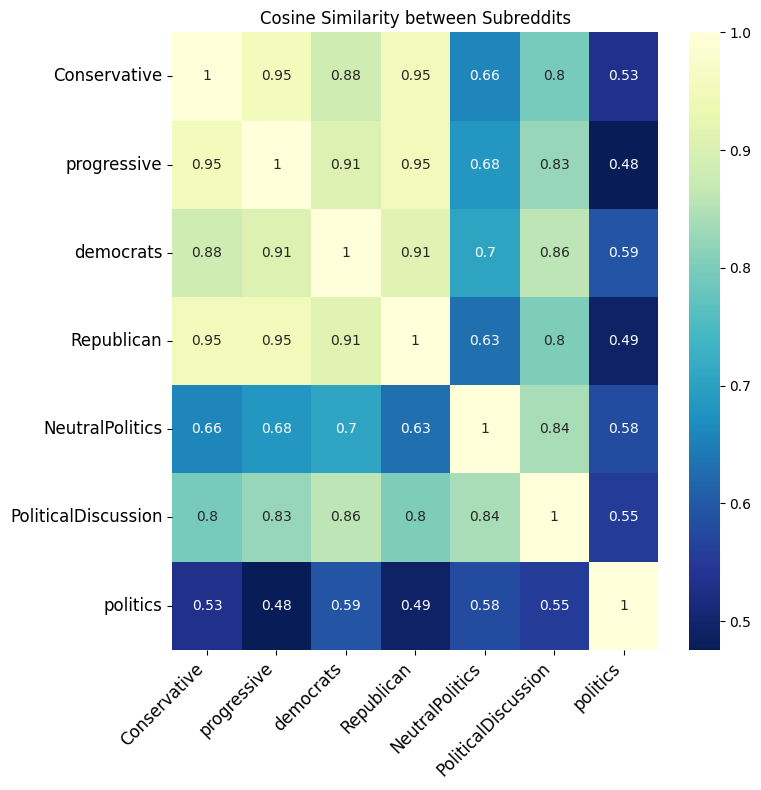

In [73]:
# Visualize the cosine similarity matrix using seaborn
plt.figure(figsize=(8,8))
sns.heatmap(similarity, annot=True, xticklabels=subreddit_order, yticklabels=subreddit_order, cmap="YlGnBu_r")
plt.title("Cosine Similarity between Subreddits")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
#plt.savefig("analysis/eda/cosine_similarity.png")
plt.close()